# Halo Data and Healpy

I've built a class (<code>halo.py</code>) to load halo data.

In [20]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from halo import *
from scipy.stats import maxwell
from colossus.cosmology import cosmology
from colossus.lss import mass_function

In [2]:
# Parameters for maps and catalogs
nside = 128  
npix = hp.nside2npix(nside)
snapshot_numbers = range(48, 63)

## CMB Convergence

I load the convergence map associated with snapshot 48 and show the results.

In [3]:
# Load the CMB convergence map at redshift 0.5 and downgrade it to match the halo map nside
map_file = 'KappaMap_snap_048.DM.seed_100672.fits'
print("Reading KappaMap_snap_048.DM.seed_100672.fits")
cmb_map = hp.read_map(map_file)
cmb_map_downgraded = hp.ud_grade(cmb_map, nside)

Reading KappaMap_snap_048.DM.seed_100672.fits


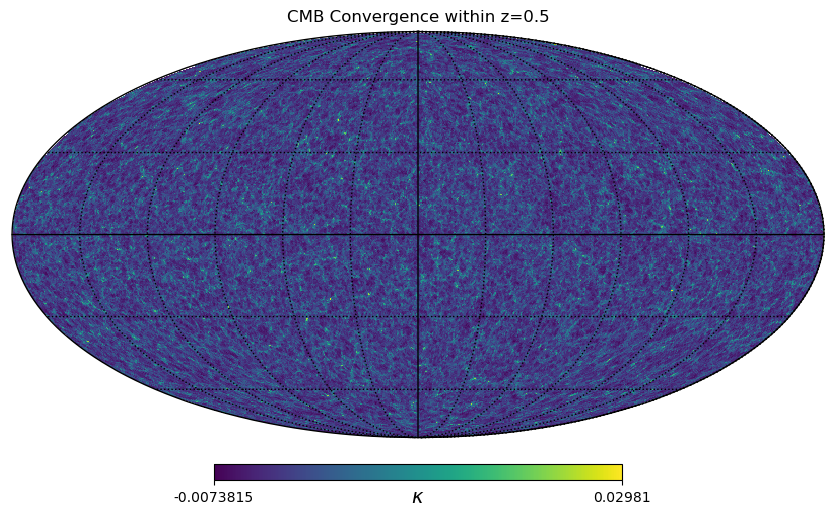

In [4]:
# Display the downgraded CMB convergence map
hp.mollview(cmb_map_downgraded, title="CMB Convergence within z=0.5", unit=r"$\kappa$")
hp.graticule()

## Halos

I load the halos for a generic snapshot and, for each halo, I display its angular position in a scatter plot. For the same snapshot, I also show the halo mass distribution.

Reading AllSkyMock_snap_048_0.bin0
Reading AllSkyMock_snap_048_1.bin0
Reading AllSkyMock_snap_048_2.bin0
Reading AllSkyMock_snap_048_3.bin0


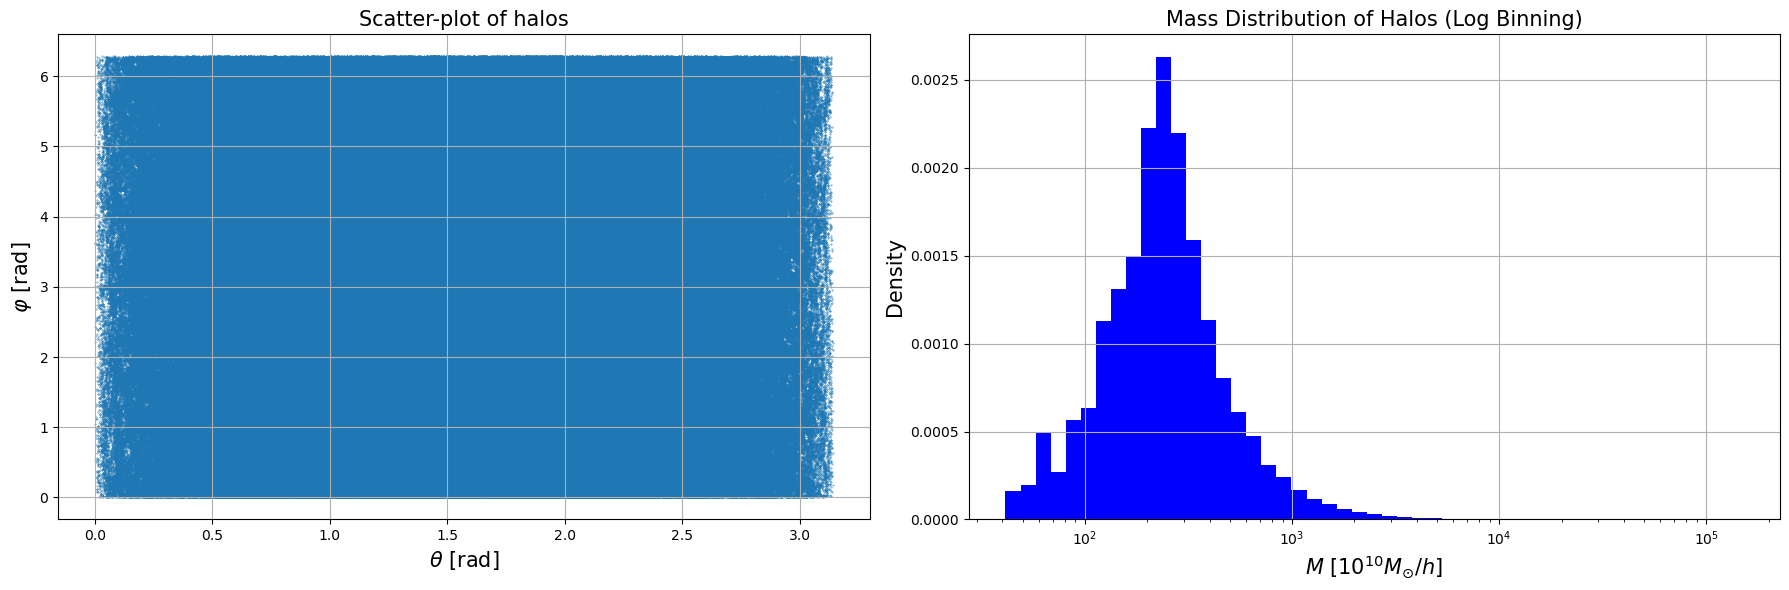

In [5]:
snapshot_number = 48
halos = HaloCatalog(snapshot_number)

plt.figure(figsize=(18, 6))

# Scatter plot of halos
plt.subplot(1, 2, 1)
plt.scatter(halos.theta, halos.phi, s=0.1)
plt.title('Scatter-plot of halos', fontsize=15)
plt.xlabel(r'$\theta$ [rad]', fontsize=15)
plt.ylabel(r'$\varphi$ [rad]', fontsize=15)
plt.grid()

# Histogram of halo mass with logarithmic binning
plt.subplot(1, 2, 2)
bins = np.logspace(np.log10(halos.mass.min()), np.log10(halos.mass.max()), 50)
plt.hist(halos.mass, bins=bins, color='blue', density = True)
plt.title('Mass Distribution of Halos (Log Binning)', fontsize=15)
plt.xlabel(r'$M$ [$10^{10} M_{\odot}/h$]', fontsize = 15)
plt.ylabel('Density', fontsize=15)
plt.xscale('log') 
plt.grid()

plt.tight_layout()
plt.show()

### Colossus Fit
Website of [colossus](https://bdiemer.bitbucket.io/colossus/lss_mass_function.html) and website of [MassFunction](https://bdiemer.bitbucket.io/colossus/lss_mass_function.html#lss.mass_function.massFunction). I use the Colossus module in Python to obtain the theoretical curve of $ \frac{dn}{d\ln M} $ and normalize the previously obtained halo mass distribution plot to check its behavior.

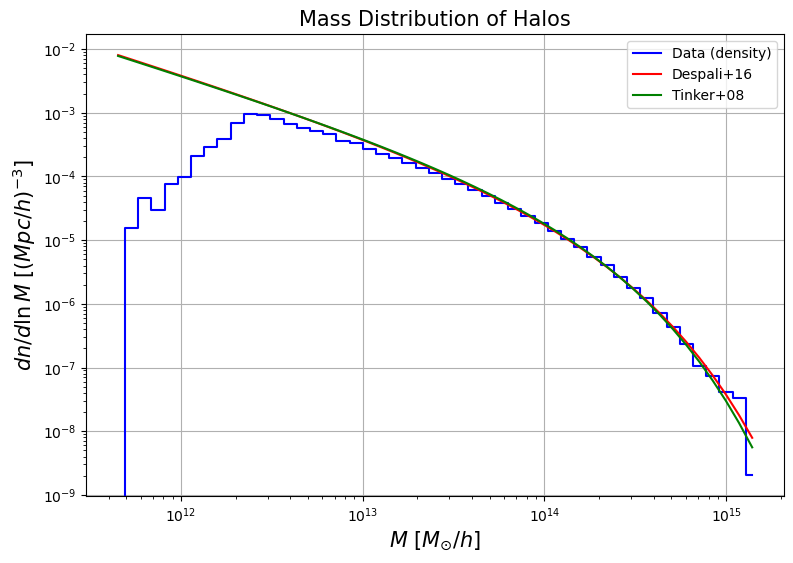

In [6]:
cosmo = cosmology.setCosmology('planck18')

# Load data using numpy, ignoring the first comment row
data = np.loadtxt('new_cosmoint_results.txt', skiprows=1)
np.savetxt('new_cosmoint_results.csv', data, delimiter=',', header='col1,col2,col3,...', comments='')
dx = data[:, -3]
index = np.where(data[:, 0] == snapshot_number)[0][0]
z = data[index, 1]
L_box_2 = np.sum(dx[:index]) * (10**(-3))
index = np.where(data[:, 0] == snapshot_number+1)[0][0]
L_box_1 = np.sum(dx[:index]) * (10**(-3))

# Simulation box volume (in Mpc^3/h^3)
volume = (L_box_2**3 - L_box_1**3)
masses = (halos.mass * (10**10))

# Mass range to calculate the mass function
mass_bins = np.logspace(np.log10(masses.min()), np.log10(masses.max()), 50)
bin_centers = 0.5 * (mass_bins[1:] + mass_bins[:-1]) 

# Calculate the mass function according to Despali et al. (2016)
dndlnm = mass_function.massFunction(bin_centers, z=z, mdef='200c', model='despali16', q_out='dndlnM')
dndlnm2 = mass_function.massFunction(bin_centers, z=z, mdef='200c', model='tinker08', q_out='dndlnM')

# Create the plot
plt.figure(figsize=(9, 6))
hist_counts, bins = np.histogram(halos.mass * (10**10), bins=mass_bins)

# Calculate the histogram without normalization
hist, bin_edges = np.histogram(masses, bins=mass_bins)
# Convert to number density
hist_density = hist_counts / volume

plt.plot(bin_centers, hist_density, drawstyle='steps-mid', color='blue', label='Data (density)')
plt.plot(bin_centers, dndlnm, label='Despali+16', color = 'red')
plt.plot(bin_centers, dndlnm2, label='Tinker+08', color = 'green')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M$ [$M_{\odot}/h$]', fontsize=15)
plt.ylabel(r'$dn/d\ln M$ [$(Mpc/h)^{-3}$]', fontsize=15)
plt.title('Mass Distribution of Halos', fontsize=15)
plt.legend()
plt.grid()
plt.show()


### Analysis of halo velocity
I now load the halos from three different snapshots and plot the velocity distribution as a function of halo mass.

Reading AllSkyMock_snap_060_0.bin0
Reading AllSkyMock_snap_060_1.bin0
Reading AllSkyMock_snap_060_2.bin0
Reading AllSkyMock_snap_060_3.bin0
Reading AllSkyMock_snap_055_0.bin0
Reading AllSkyMock_snap_055_1.bin0
Reading AllSkyMock_snap_055_2.bin0
Reading AllSkyMock_snap_055_3.bin0
Reading AllSkyMock_snap_048_0.bin0
Reading AllSkyMock_snap_048_1.bin0
Reading AllSkyMock_snap_048_2.bin0
Reading AllSkyMock_snap_048_3.bin0


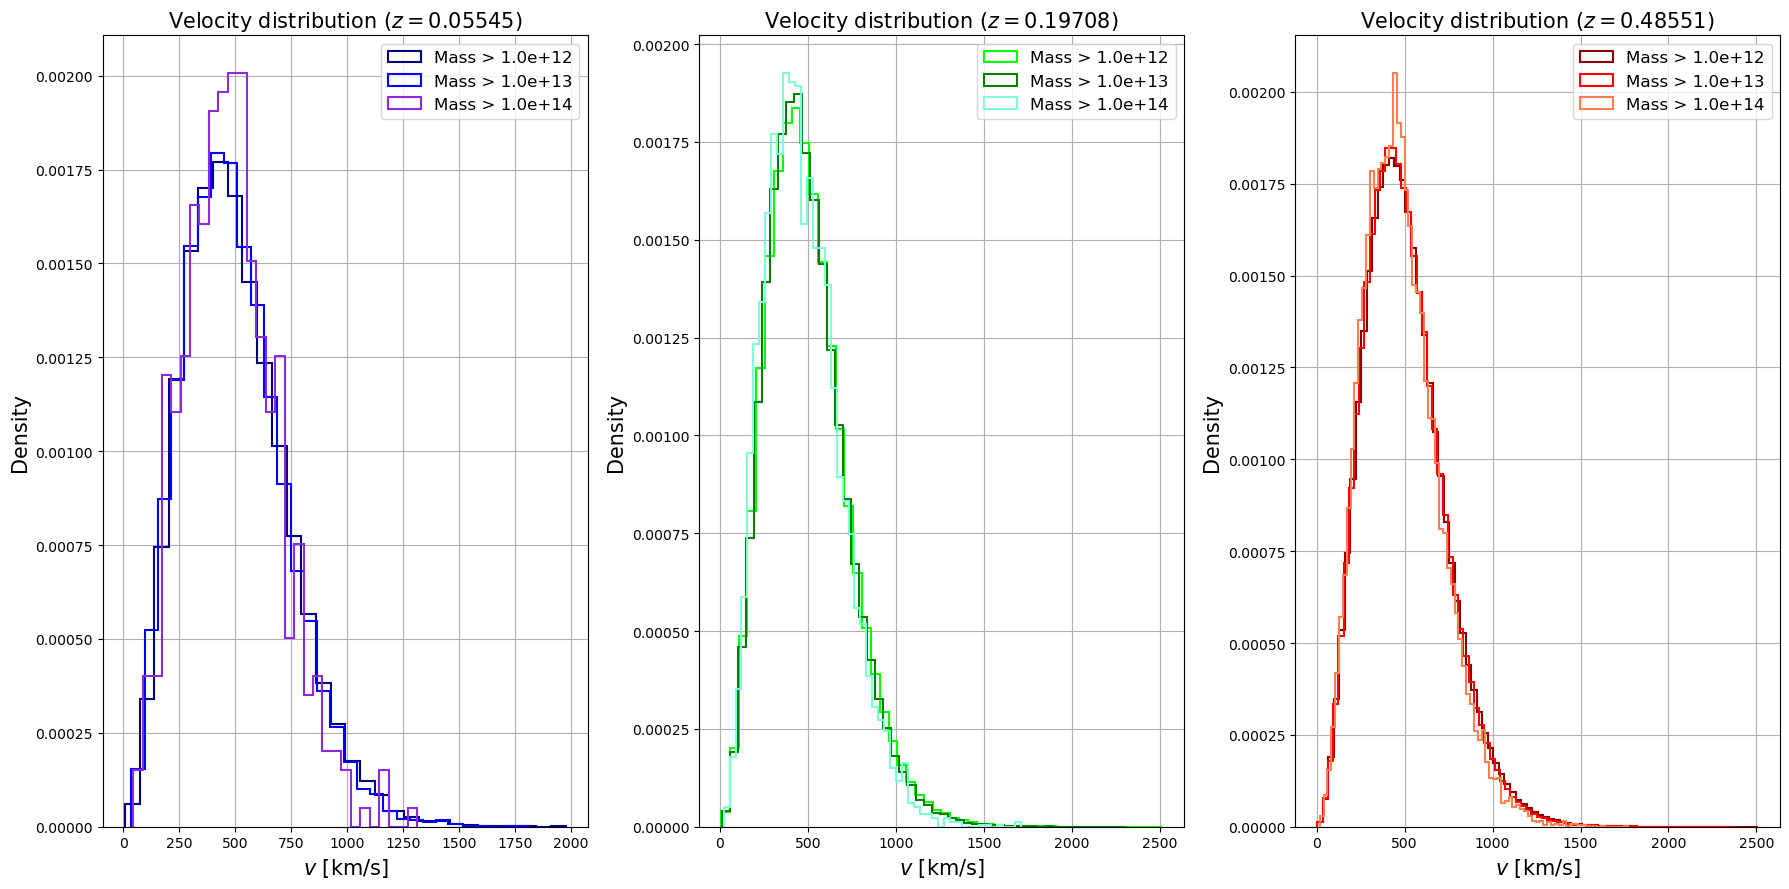

In [7]:
manager = HaloCatalogManager([60, 55, 48])
mass_thresholds = [1e2, 1e3, 1e4]
snapshots = manager.snapshot_numbers

bins = [30, 50, 80]
colors = ["navy",  "lime",  "darkred", "blue", "green", "red", "blueviolet", "aquamarine", "coral"]

i = 1
j = 0
plt.figure(figsize=(18, 9))
# Calculate velocities for each mass threshold
for threshold in mass_thresholds:
    filtered_manager = manager.select_mass_above(threshold)
    velocities = filtered_manager.calculate_velocity()
    
    
    for catalog_velocity, snapshot_number, b in zip(velocities, snapshots, bins):
        v_min = np.min(catalog_velocity)
        v_max = np.max(catalog_velocity)
        z = manager.catalogs[i-1].redshift
        
        plt.subplot(1, 3, i)
        plt.hist(catalog_velocity, bins=b, histtype='step', lw=1.5, range=(v_min, v_max), density=True, color = colors[j], label=f'Mass > {threshold*(10**10):.1e}')
        plt.title(fr'Velocity distribution ($z = {z}$)', fontsize=15)
        
        plt.xlabel('$v$ [km/s]', fontsize=15)
        plt.ylabel('Density', fontsize=15)
        plt.legend(fontsize=12)
        plt.grid()
        
        i+=1
        j+=1
    
    i=1
plt.tight_layout()
plt.show()

### Load all halos
I now load all the halos in snapshots with $ z < 0.5 $.

In [8]:
# Select halo catalogs with z < 0.5 and initialize the manager
manager = HaloCatalogManager(snapshot_numbers)

# Set a mass threshold and apply a filter to halos
mass_threshold = 1e2
filtered_manager = manager.select_mass_above(mass_threshold)

# Retrieve the angular coordinates of halos and convert them into pixel indices
theta = np.concatenate(filtered_manager.theta)
phi = np.concatenate(filtered_manager.phi)
pix_indices = hp.ang2pix(nside, theta, phi)

# Count the number of halos in each pixel
halo_map = np.zeros(npix)
for pix in pix_indices:
    halo_map[pix] += 1

Reading AllSkyMock_snap_048_0.bin0
Reading AllSkyMock_snap_048_1.bin0
Reading AllSkyMock_snap_048_2.bin0
Reading AllSkyMock_snap_048_3.bin0
Reading AllSkyMock_snap_049_0.bin0
Reading AllSkyMock_snap_049_1.bin0
Reading AllSkyMock_snap_049_2.bin0
Reading AllSkyMock_snap_049_3.bin0
Reading AllSkyMock_snap_050_0.bin0
Reading AllSkyMock_snap_050_1.bin0
Reading AllSkyMock_snap_050_2.bin0
Reading AllSkyMock_snap_050_3.bin0
Reading AllSkyMock_snap_051_0.bin0
Reading AllSkyMock_snap_051_1.bin0
Reading AllSkyMock_snap_051_2.bin0
Reading AllSkyMock_snap_051_3.bin0
Reading AllSkyMock_snap_052_0.bin0
Reading AllSkyMock_snap_052_1.bin0
Reading AllSkyMock_snap_052_2.bin0
Reading AllSkyMock_snap_052_3.bin0
Reading AllSkyMock_snap_053_0.bin0
Reading AllSkyMock_snap_053_1.bin0
Reading AllSkyMock_snap_053_2.bin0
Reading AllSkyMock_snap_053_3.bin0
Reading AllSkyMock_snap_054_0.bin0
Reading AllSkyMock_snap_054_1.bin0
Reading AllSkyMock_snap_054_2.bin0
Reading AllSkyMock_snap_054_3.bin0
Reading AllSkyMock_s

## Load Convergenge maps

I load the convergence maps and sum the convergence values pixel by pixel. The halo.py library is structured to remove the geometric lensing weight due to the CMB. In order to obtain a consistent plot, it was multiplied by the weight generated from a source at a redshift of 0.5.

In [21]:
cmb_map_sum = np.zeros(npix)

data = np.loadtxt('new_cosmoint_results.txt', skiprows=1)
cmb_weight = data[:, -1]
z_l = data[:, 1]


for snapshot_num in snapshot_numbers:
    index = np.where(data[:, 0] == snapshot_num)[0][0]
    
    map_file = f'KappaMap_snap_{snapshot_num:03d}.DM.seed_100672.fits'
    print(f"Reading {map_file}")
    cmb_map = lens_weight(z_l[index], 0.485510) * ((1/cmb_weight[index])) * hp.read_map(map_file)
    
    cmb_map_downgraded = hp.ud_grade(cmb_map, nside)
    cmb_map_sum +=  cmb_map_downgraded

Reading KappaMap_snap_048.DM.seed_100672.fits
Reading KappaMap_snap_049.DM.seed_100672.fits
Reading KappaMap_snap_050.DM.seed_100672.fits
Reading KappaMap_snap_051.DM.seed_100672.fits
Reading KappaMap_snap_052.DM.seed_100672.fits
Reading KappaMap_snap_053.DM.seed_100672.fits
Reading KappaMap_snap_054.DM.seed_100672.fits
Reading KappaMap_snap_055.DM.seed_100672.fits
Reading KappaMap_snap_056.DM.seed_100672.fits
Reading KappaMap_snap_057.DM.seed_100672.fits
Reading KappaMap_snap_058.DM.seed_100672.fits
Reading KappaMap_snap_059.DM.seed_100672.fits
Reading KappaMap_snap_060.DM.seed_100672.fits
Reading KappaMap_snap_061.DM.seed_100672.fits
Reading KappaMap_snap_062.DM.seed_100672.fits


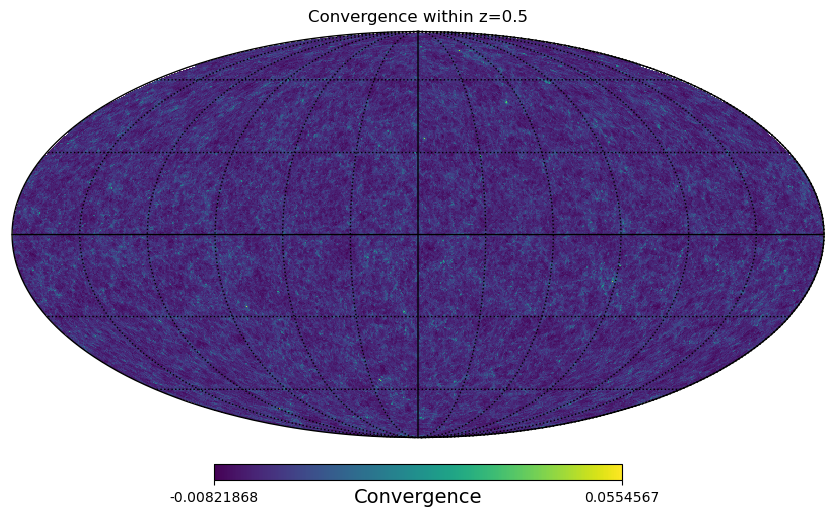

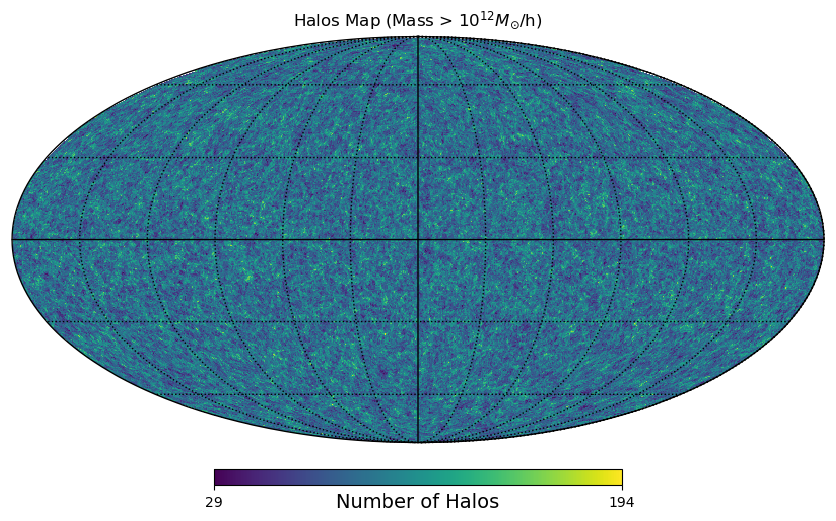

In [55]:
hp.mollview(cmb_map_sum, title="Convergence within z=0.5", unit="Convergence")
hp.graticule()

# Display the halo map
hp.mollview(halo_map, title=r'Halos Map (Mass > $10^{12} M_{\odot}$/h)', unit='Number of Halos')
hp.graticule()

## Cross correlation

Now the cross-correlation between the convergence and the halo number contrast is shown.

In [73]:
#------------------ CROSS CORRELATION ----------------------

mean_halo_count = np.mean(halo_map)
halo_contrast = (halo_map - mean_halo_count) / mean_halo_count
cross_correlation_kappa = hp.anafast(halo_contrast, cmb_map_sum)

cmb_map_sum_no_dipole = hp.remove_dipole(cmb_map_sum)
cross_correlation_kappa_no_dipole = hp.anafast(halo_contrast, cmb_map_sum_no_dipole)

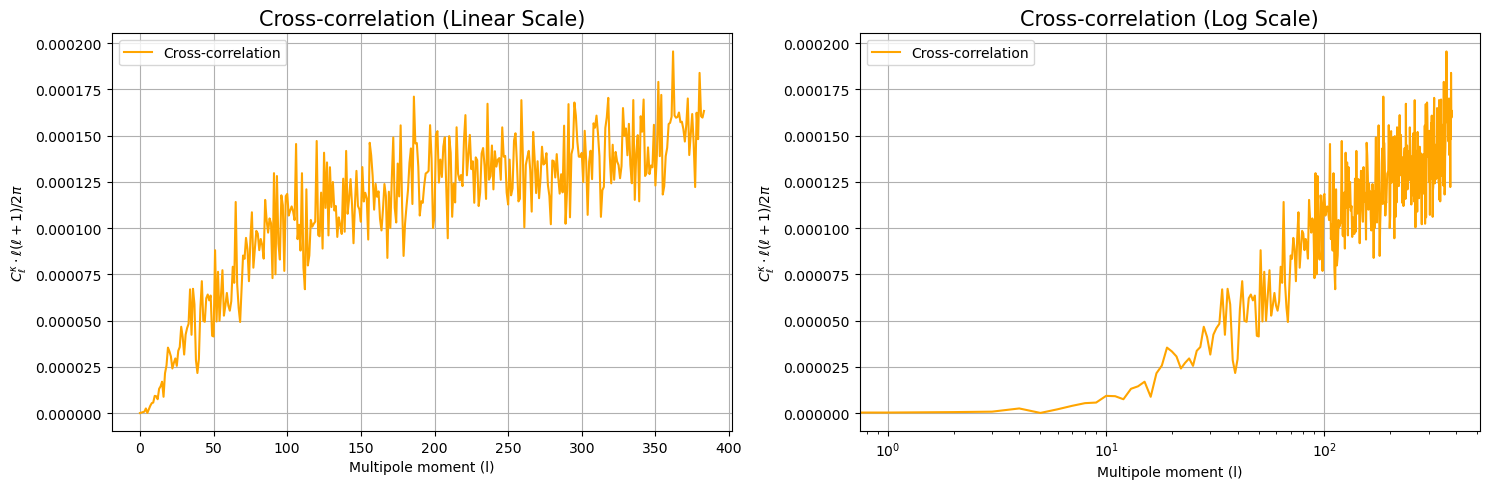

In [74]:
l = np.arange(len(cross_correlation))
plt.figure(figsize=(15, 5))

# Linear scale
plt.subplot(1, 2, 1)
plt.plot(l, cross_correlation_kappa * l * (l + 1)/(2 * np.pi), label='Cross-correlation', color='orange')
plt.xlabel('Multipole moment (l)')
plt.ylabel(r'$C_\ell^\kappa \cdot \ell(\ell+1)/2\pi$')
plt.title('Cross-correlation (Linear Scale)', fontsize=15)
plt.legend()
plt.grid()

# Log scale
plt.subplot(1, 2, 2)
plt.plot(l, cross_correlation_kappa * l * (l + 1)/(2 * np.pi), label='Cross-correlation', color='orange')
plt.xscale('log')
plt.xlabel('Multipole moment (l)')
plt.ylabel(r'$C_\ell^\kappa \cdot \ell(\ell+1)/2\pi$')
plt.title('Cross-correlation (Log Scale)', fontsize=15)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Lensing potential calculation

I will now proceed with calculating the lensing potential from the convergence map. To better visualize the anisotropies, I remove the dipole term.

In [75]:
#------------------ LENSING POTENTIAL ----------------------

######################### FUNCTIONS ##########################

# Solve the equation for the lensing potential: ∇² ψ = 2 κ
# In Fourier space, l(l+1) ψ_{lm} = 2 κ_{lm}
# Thus, ψ_{lm} =  2 κ_{lm} / [l(l+1)]

# Calculate the lensing potential (psi) from the convergence map
def calculate_lensing_potential(kappa_map):
    
    # Set lmax and transform the kappa_map into spherical harmonics
    lmax = 2 * nside + 1
    kappa_alm = hp.map2alm(kappa_map, lmax=lmax)

    # For each l and m, 
    # calculate the corresponding psi_{lm} by multiplying κ_{lm} * 2 / [l(l+1)]
    # 1. l = 0 is excluded since it is in the denominator
    # 2. healpy uses only m > 0
    psi_alm = np.zeros_like(kappa_alm, dtype=complex)
    for l in range(1, lmax + 1): 
        factor = 2 / (l * (l + 1))
        for m in range(l + 1):
            index = hp.Alm.getidx(lmax, l, m)
            psi_alm[index] = factor * kappa_alm[index]

    # Transform psi_{lm} back into real space to get psi_map
    return hp.alm2map(psi_alm, nside=nside, lmax=lmax)

def calculate_lensing_potential_2(kappa_map):
    # Set lmax and transform the kappa_map into spherical harmonics
    lmax = 2 * nside + 1
    kappa_alm = hp.map2alm(kappa_map, lmax=lmax)

    # Create a scaling factor for the lensing potential
    # 2 / [l(l+1)] for l = 1 to lmax
    l_values = np.arange(1, lmax + 1)
    factors = 2 / (l_values * (l_values + 1))
    
    # Multiply the kappa_alm by the scaling factors using almxfl
    # Note: lmax should be the same for kappa_alm and the factors
    psi_alm = hp.almxfl(kappa_alm, factors)

    # Transform psi_{lm} back into real space to get psi_map
    return hp.alm2map(psi_alm, nside=nside, lmax=lmax)


#############################################################

# Calculate the lensing potential
lensing_potential = calculate_lensing_potential_2(cmb_map_sum)

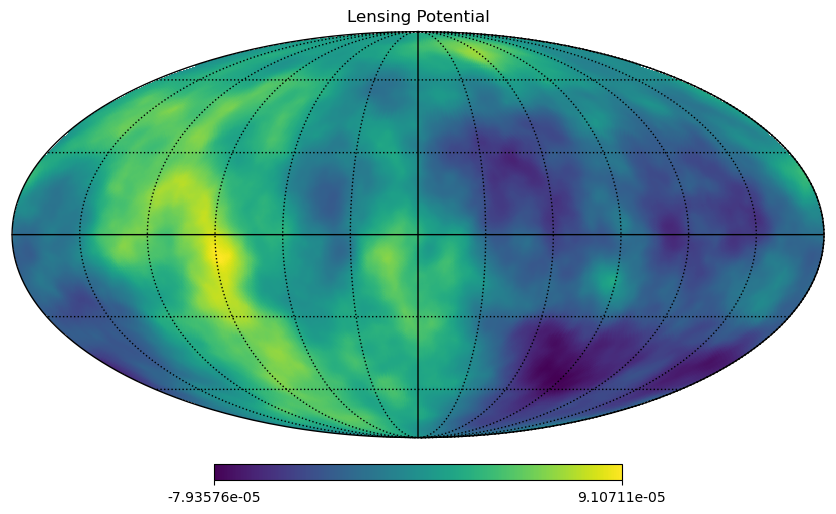

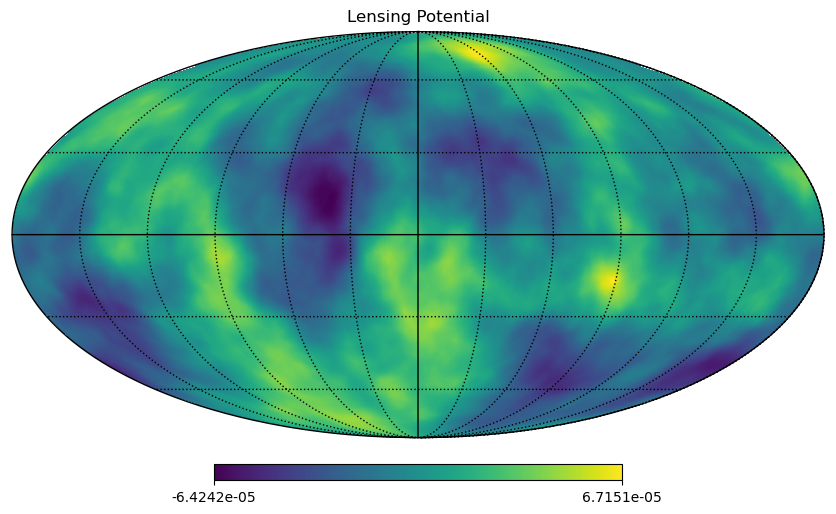

In [76]:
# Display the lensing potential map
hp.mollview(lensing_potential, title='Lensing Potential')
hp.graticule()
plt.show()

psi_map_no_dipole = hp.remove_dipole(lensing_potential)
hp.mollview(psi_map_no_dipole, title='Lensing Potential')
hp.graticule()
plt.show()

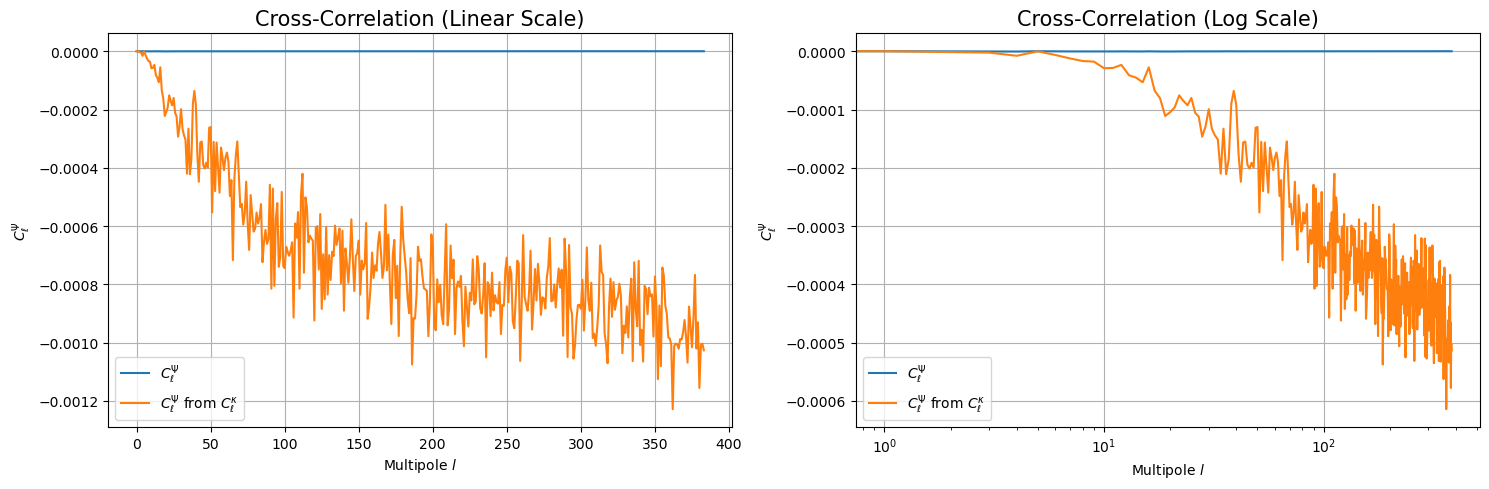

In [86]:
# Compute the cross-correlation between the halo map and the lensing potential map
cross_correlation = hp.anafast(halo_contrast, psi_map_no_dipole)

# Plot the cross-correlation between the halo map and lensing potential
l = np.arange(len(cross_correlation))
cross_correlation_modified = -0.5 * l * (l + 1) * cross_correlation

plt.figure(figsize=(15, 5))
# Linear scale
plt.subplot(1, 2, 1)
plt.plot(l, cross_correlation_modified, label=r'$C_\ell^\Psi$')
plt.plot(l, - cross_correlation_kappa_no_dipole * l * (l+1), label=r'$C_\ell^\Psi$ from $C_\ell^\kappa$')
plt.xlabel(r'Multipole $l$')
plt.ylabel(r'$C_\ell^\Psi$')
plt.title('Cross-Correlation (Linear Scale)', fontsize=15)
plt.legend()
plt.grid()

# Log scale
plt.subplot(1, 2, 2)
plt.plot(l, cross_correlation_modified, label=r'$C_\ell^\Psi$')
plt.plot(l, - cross_correlation_kappa_no_dipole * 0.5 * l * (l+1), label=r'$C_\ell^\Psi$ from $C_\ell^\kappa$')
plt.xscale('log')
plt.xlabel(r'Multipole $l$')
plt.ylabel(r'$C_\ell^\Psi$')
plt.title('Cross-Correlation (Log Scale)', fontsize=15)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()